# Modelo Predictivo de Estimación de Presión Arterial

**Procesamiento de la Data:**
Utilizamos la data que esta en .mat, por lo que tenemos que agruparla en mediciones de 10 segundos como se va a utilizar en la realidad. Asi tenemos un numero  de muestras establecido.

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import zipfile
import os
import shutil

import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models

## Se descarga un dataset
Dataset público (no MIMIC-II, sino del UCI Machine Learning Repository).

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip

--2025-07-24 19:27:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.zip’

data.zip                [              <=>   ] 622.03M  12.7MB/s               ^C


## Descompresion de Datos
Se descomprimen los datos y crea una carpeta raw_data, donde se almacenaran los archivos



In [3]:


# Descomprimir en carpeta temporal
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/temp_data')

print("Archivo descomprimido en /content/temp_data")

# Crear carpeta raw_data si no existe
os.makedirs('/content/raw_data', exist_ok=True)

# Mover todo lo descomprimido a raw_data
for root, dirs, files in os.walk('/content/temp_data'):
    for file in files:
        src = os.path.join(root, file)
        dst = os.path.join('/content/raw_data', file)
        shutil.move(src, dst)

print("Archivos movidos a /content/raw_data")

# (Opcional) Verificar los archivos
print("\Archivos en /content/raw_data:")
for f in os.listdir('/content/raw_data'):
    print(f)

BadZipFile: File is not a zip file

## Funciones para Preprocesamiento
Se declaran funciones que seran empleadas para procesar los datos

In [ ]:
#lleva cada segmento a un rango de [0,1]
def normalize(segment):
    min_val = np.min(segment)
    max_val = np.max(segment)
    if np.isclose(max_val, min_val):
        return np.zeros_like(segment)
    return (segment - min_val) / (max_val - min_val)

#Filtra la banda de 0.5 a 8 Hz
def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=125, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

#Corta la señal en ventanas de 1024 muestras (8.2 s a 125 Hz).
#Usa stride de 128
def segmentar(signal, bp, segment_length=1024, stride=128):
    X, Y = [], []
    # Aplicar filtro pasa banda a la señal PPG
    signal = bandpass_filter(signal)
    for i in range(0, len(signal) - segment_length + 1, stride):
        ppg_seg = signal[i:i+segment_length]
        abp_seg = bp[i:i+segment_length]

        # VALIDACIÓN OPCIONAL: descartar segmentos planos o ruidosos
        if np.std(ppg_seg) < 0.01 or np.std(abp_seg) < 0.01:
          continue


        #Normaliza solo la entrada, el PPG()
        ppg_seg = normalize(ppg_seg)

        # Etiquetas de salida, es el objetivo del modelo a evaluar
        sbp = np.max(abp_seg)
        dbp = np.min(abp_seg)

        X.append(ppg_seg)
        Y.append([sbp, dbp])

    return np.array(X), np.array(Y)

Se procesan los datos

In [ ]:



#definicion de archivos de entrada
archivos = ['raw_data/Part_1.mat', 'raw_data/Part_2.mat', 'raw_data/Part_3.mat', 'raw_data/Part_4.mat']
output_dir = 'segmentos_guardados'
os.makedirs(output_dir, exist_ok=True)

segment_count = 0
registro_procesado = 0

for archivo in archivos:
    grupo_id = os.path.splitext(os.path.basename(archivo))[0]
    print(f'\Procesando: {archivo}')

    with h5py.File(archivo, 'r') as f:
      #se verifica que el grupo exista
        if grupo_id not in f:
            print(f'Grupo {grupo_id} no encontrado en {archivo}')
            continue

        registros = f[grupo_id]
        print(f'Total registros en {grupo_id}: {len(registros)}')

        for i in tqdm(range(len(registros)), desc=f'{grupo_id} registros'):
            try:
                ref = registros[i][0]
                record = f[ref][()]

                #se descarta si no es el formato esperado
                if record.ndim != 2 or record.shape[1] < 2:
                    print(f'Registro {i} inválido: forma {record.shape}')
                    continue
                #extrae la columna 0 como señal ppg y la columna 1 como presion arterial
                signal = record[:, 0]
                bp = record[:, 1]

                #segmentamos las señales
                X_seg, Y_seg = segmentar(signal, bp)

                if X_seg.size > 0:

                    #redimenciona
                    X_seg = X_seg[..., np.newaxis].astype(np.float32)
                    Y_seg = Y_seg.astype(np.float32)

                    np.save(os.path.join(output_dir, f'X_seg_{segment_count}.npy'),
                            X_seg)
                    np.save(os.path.join(output_dir, f'Y_seg_{segment_count}.npy'),
                            Y_seg)

                    segment_count += 1
                    registro_procesado += 1
                else:
                    print(f'Registro {i} sin segmentos válidos')
            except Exception as e:
                print(f'Error en registro {i}: {e}')

print(f'\n Proceso terminado.')
print(f'Registros procesados con segmentos: {registro_procesado}')
print(f'Archivos .npy guardados: {segment_count}')
print(f'Archivos en carpeta {output_dir}: {len(os.listdir(output_dir)) // 2} pares')



HASTA ACA EL PREPROCESAMIENTO
(Detalle, dividir mejor la data del test y train de distinta manera) Al ser bastante data no alcanza la RAM para procesar todo. Se puede hacer una carpeta adicional donde se divida una carpeta TRAIN y TEST

## Creacion del modelo
Se pasan los valores procesado a x y y

#### Combinar Multiples Archivos


In [ ]:
# Cambia el número de archivos que quieres cargar (10, 20, etc.)
max_archivos = 5

# Buscar todos los archivos
X_files = sorted(glob.glob('segmentos_guardados/X_seg_*.npy'))[:max_archivos]
Y_files = sorted(glob.glob('segmentos_guardados/Y_seg_*.npy'))[:max_archivos]

In [ ]:

#Probar con pocos datos
#X = np.load('segmentos_guardados/X_seg_1.npy')
#Y = np.load('segmentos_guardados/Y_seg_1.npy')

# Cargar y concatenar
X = np.concatenate([np.load(f) for f in X_files], axis=0)
Y = np.concatenate([np.load(f) for f in Y_files], axis=0)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

In [ ]:
# Primera división: separa el 70% para entrenamiento y 30% para el resto
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
# Segunda división: divide ese 30% en mitad para validación y mitad para prueba
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [ ]:


def unet_1d(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    p1 = layers.MaxPooling1D(2)(x1)

    x2 = layers.Conv1D(128, 3, padding='same', activation='relu')(p1)
    p2 = layers.MaxPooling1D(2)(x2)

    # Bottleneck
    bn = layers.Conv1D(256, 3, padding='same', activation='relu')(p2)

    # Decoder
    u2 = layers.UpSampling1D(2)(bn)
    c2 = layers.concatenate([u2, x2])
    x3 = layers.Conv1D(128, 3, padding='same', activation='relu')(c2)

    u1 = layers.UpSampling1D(2)(x3)
    c1 = layers.concatenate([u1, x1])
    x4 = layers.Conv1D(64, 3, padding='same', activation='relu')(c1)

    outputs = layers.Conv1D(1, 1, activation='linear')(x4)

    return models.Model(inputs, outputs)

def cnn_regresion_1d(input_shape=(1024, 1)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(2, activation='linear')(x)  # SBP y DBP

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def cnn_and_rnn(input_shape=(1024, 1)):
    inputs = layers.Input(shape=input_shape)

    #  Etapa convolucional
    x = layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Etapa recurrente
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)

    # Densas finales
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(2, activation='linear')(x)  # SBP, DBP

    return models.Model(inputs=inputs, outputs=outputs)



## Entrenamiento del modelo

Se entrena el modelo con los datos correspondientes

In [ ]:
#model = unet_1d((1024, 1))
#cnn normal con validaciones
#model = cnn_regresion_1d((1024, 1))
#cnn + rnn
model = cnn_and_rnn((1024, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=30,
                    batch_size=64)


## Pruebes del rendimiento del modelo


### Graficos de prediccion
predicion del vector [SBD,DBP]

In [8]:
# Elegir índice a visualizar
i = 0

# Real y predicción
pred = model.predict(X_test[i:i+1])[0]  # pred: [SBP_pred, DBP_pred]
real = Y_test[i]                        # real: [SBP_real, DBP_real]


print(f"SBP real: {real[0]:.2f} - predicho: {pred[0]:.2f}")
print(f"DBP real: {real[1]:.2f} - predicho: {pred[1]:.2f}")

# Visualización tipo barras

labels = ['SBP', 'DBP']
x = np.arange(len(labels))

plt.bar(x - 0.15, real, width=0.3, label='Real')
plt.bar(x + 0.15, pred, width=0.3, label='Predicción')
plt.xticks(x, labels)
plt.ylabel('Presión (mmHg)')
plt.title('Comparación SBP/DBP: Real vs Predicho')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Entrenamiento del modelo y guardar el historial

# Graficar loss y accuracy

# Graficar Entropía de Pérdida
plt.figure(figsize=(12, 6))

# Pérdida en entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Train)')
plt.plot(history.history['val_loss'], label='Pérdida (Validation)', linestyle='--')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Exactitud de clasificación
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Exactitud (Train)')
plt.plot(history.history['val_mae'], label='Exactitud (Validation)', linestyle='--')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()

plt.tight_layout()
plt.show()


🧠 Modelo cargado correctamente...

📊 Estimación SBP y DBP:
🟦 Modelo .h5 → SBP: 136.210, DBP: 67.762


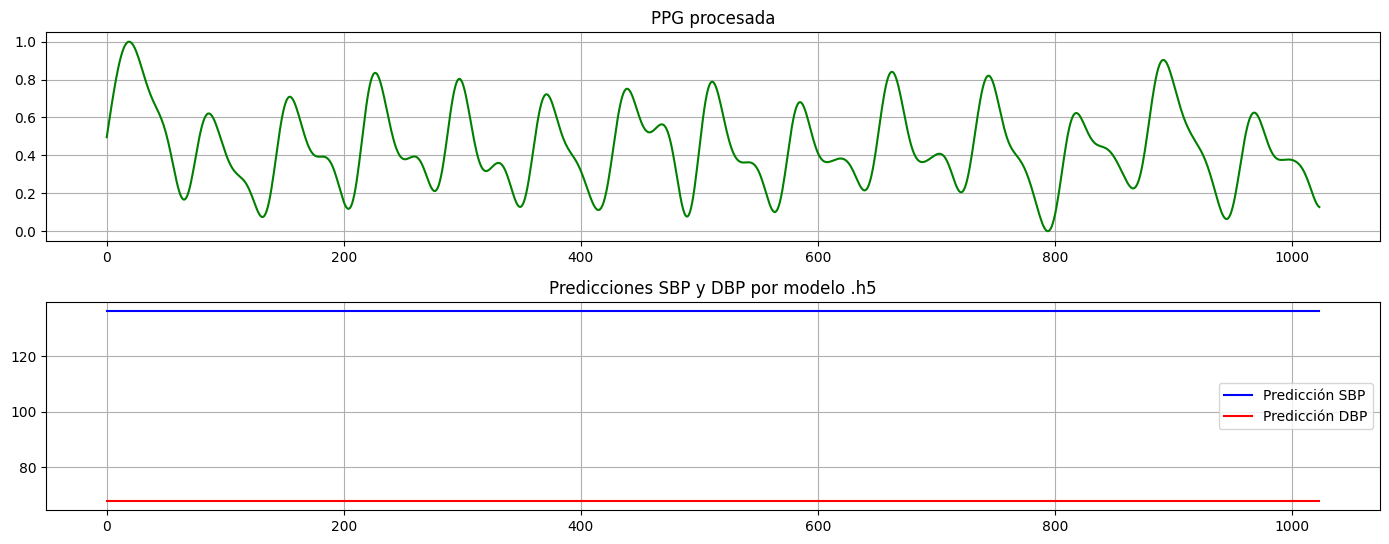

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error

def cargar_archivo_excel(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo {file_path} no se encuentra.")

    try:
        df = pd.read_excel(file_path, header=None)
        df = df[1:]  # Eliminar la primera fila si contiene encabezados no útiles
        df.columns = ['timestamp', 'ppg_A', 'ppg_B']
        return df
    except Exception as e:
        raise ValueError(f"Error al cargar el archivo Excel: {e}")

file_path = "maraton.xlsx" #Muestreo Obtenido del sensor


df = cargar_archivo_excel(file_path)


ppg_raw = pd.to_numeric(df['ppg_A'], errors='coerce').dropna().astype(float).values


def eliminar_tendencia(ppg_raw):
    rolling_mean = pd.Series(ppg_raw).rolling(window=200, center=True, min_periods=1).mean()
    return ppg_raw - rolling_mean

ppg_detrended = eliminar_tendencia(ppg_raw)


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

fs = 125
ppg_filtered = butter_bandpass_filter(ppg_detrended, 0.5, 5.0, fs)


def recortar_a_muestras(ppg_filtered, num_muestras=1024):
    if len(ppg_filtered) < num_muestras:
        raise ValueError(f"La señal es más corta de {num_muestras} muestras.")
    return ppg_filtered[:num_muestras]

ppg_final = recortar_a_muestras(ppg_filtered)


def normalizar(ppg_final):
    ppg_min = np.min(ppg_final)
    ppg_max = np.max(ppg_final)
    return (ppg_final - ppg_min) / (ppg_max - ppg_min)

ppg_norm = normalizar(ppg_final)


ppg_input = ppg_norm.reshape(1, 1024, 1).astype(np.float32)  # Se mantiene la forma para 1 muestra


def cargar_modelo(model_path):
    try:
        model = tf.keras.models.load_model(model_path, compile=False)
        return model
    except Exception as e:
        raise ValueError(f"Error al cargar el modelo: {e}")

modelo_path = 'model_compatible.h5'

try:
    full_model = cargar_modelo(modelo_path)
    print("Modelo cargado correctamente...")
except ValueError as e:
    print(e)
    full_model = None

if full_model:
    # Hacer la predicción
    sbp_full, dbp_full = full_model.predict(ppg_input, verbose=0)[0]  # Modelo con dos salidas (SBP y DBP)

    # Cálculo de error absoluto medio (MAE) si tienes los valores reales (opcional)
    # mae_sbp = mean_absolute_error([sbp_full], real_sbp_values)
    # mae_dbp = mean_absolute_error([dbp_full], real_dbp_values)

    print(f"\nEstimación SBP y DBP:")
    print(f"Modelo .h5 SBP: {sbp_full:.3f}, DBP: {dbp_full:.3f}")


else:
    print("No se pudo cargar el modelo .h5.")


In [ ]:
# Configurar el convertidor para habilitar variables de recursos
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True

tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('model_compatible.tflite', 'wb') as f:
    f.write(tflite_model)



In [ ]:
# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter(model_path="model_compatible.tflite")
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

# Realizar predicción con el modelo TFLite
def predict_tflite(input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Realizar predicción con el modelo TFLite en los datos de prueba
y_pred_tflite = predict_tflite(ppg_input)

print("Predicción TFLite:", y_pred_tflite)
